# Convolutional Neural Network with MNIST
*To prepare for the project, I review my knowledge by rewriting MNIST classification using CNN.*

In [1]:
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

## Load and visualize data
We can get MNIST data using PyTorch: https://pytorch.org/docs/stable/torchvision/datasets.html#mnist.

- download data to a `Dataset`
- create a `DataLoader` from `Dataset`
 - use `Sampler` to split to train and validation sets

In [2]:
def load_dataset():
    transform = transforms.ToTensor()
    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    return train_data, test_data

In [3]:
train_data, test_data = load_dataset()
len(train_data), len(test_data)

(60000, 10000)

In [4]:
def create_data_loaders(train_data, test_data, batch_size=20, train_ratio=0.8):
    train_size = len(train_data)
    indices = np.arange(train_size)
    split = int(train_size * train_ratio)
    np.random.shuffle(indices) # Randomly choose data for train and validation
    train_index = indices[:split]
    valid_index = indices[split:]

    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(train_index))
    valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(valid_index))
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, valid_loader, test_loader

In [15]:
train_loader, valid_loader, test_loader = create_data_loaders(train_data, test_data, batch_size=32)

## Visualize a batch of training data
- get a batch from data loader
- use `imshow`

In [6]:
def visualize_batch(images, labels, preds=None, n_rows=2, n_cols=10, figsize=(25,4)):
    fig = plt.figure(figsize=(25,4))
    for i in range(n_rows * n_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        text = labels[i] if preds is None else f'{preds[i]} ({labels[i]})'
        color = 'black' if preds is None else ('green' if preds[i] == labels[i] else 'red')
        ax.set_title(text, color=color)

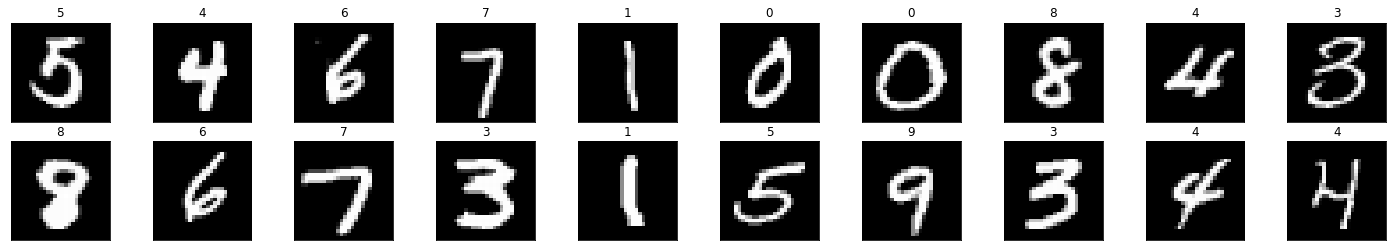

In [7]:
images, labels = iter(train_loader).next()
images = images.numpy().squeeze()
labels = labels.numpy()
visualize_batch(images, labels)

## Define network architecture
The network takes on an input of 784-dim tensor (as pixel values of an image) and produces a 10-dim tensor of class scores. A CNN typically includes:
- convolutional layers, which are stacks of filtered images
- pooling layers, which down-sample the input to make it more robust
- fully connected layers to reduce transform the feature maps to a desired output score
- and dropout to avoid overfitting

We will use
- conv. layer 1 with 16 of 3x3 kernel, padding 1
- conv. layer 2 doubles the depth to 32
- max pool (2, 2)
- dropout p=0.2
- fc. layer 1 with 512 features
- fc. layer 2 with 10 features

In [17]:
class Network(nn.Module):
    def __init__(self,):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
model = Network()
model

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train the network

First is to specify loss function and optimizer.

In [19]:
criterion = nn.CrossEntropyLoss() # takes scores as input
optimizer = optim.SGD(model.parameters(), lr=0.01)

Remember to set the training mode and follow the steps to train each batch:
1. Clear the gradients of all optimized variables
2. Run the forward pass
3. Calculate the loss
4. Run the backward propagation to compute the gradient of the loss w.r.t model parameters
5. Update parameters using optimization step
6. Update average training loss for monitoring

After training the model for each epoch, calculate the validation loss with step 2, 3 and 6.

In [23]:
def train_epoch(model, loader, criterion, optimizer):
    total_loss = 0
    model.train()
    
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    return total_loss / len(loader.sampler)

def validate_epoch(model, loader, criterion):
    total_loss = 0
    model.eval()
    
    for data, target in loader:
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)

    return total_loss / len(loader.sampler)

def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=1):
    valid_loss_min = np.Inf
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        valid_loss = validate_epoch(model, valid_loader, criterion)
        
        print(f'Epoch: {epoch+1} \tTraining loss: {train_loss:.3f} \tValidation loss: {valid_loss:.3f}')
        
        # Save model if validation has decreases
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.3f} -> {valid_loss:.3f}). Saving model...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model.pt')

In [32]:
train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10)

Epoch: 1 	Training loss: 0.060 	Validation loss: 0.055
Validation loss decreased (inf -> 0.055). Saving model...
Epoch: 2 	Training loss: 0.055 	Validation loss: 0.054
Validation loss decreased (0.055 -> 0.054). Saving model...
Epoch: 3 	Training loss: 0.049 	Validation loss: 0.052
Validation loss decreased (0.054 -> 0.052). Saving model...
Epoch: 4 	Training loss: 0.047 	Validation loss: 0.047
Validation loss decreased (0.052 -> 0.047). Saving model...
Epoch: 5 	Training loss: 0.043 	Validation loss: 0.047
Validation loss decreased (0.047 -> 0.047). Saving model...
Epoch: 6 	Training loss: 0.040 	Validation loss: 0.044
Validation loss decreased (0.047 -> 0.044). Saving model...
Epoch: 7 	Training loss: 0.036 	Validation loss: 0.046
Epoch: 8 	Training loss: 0.035 	Validation loss: 0.048
Epoch: 9 	Training loss: 0.033 	Validation loss: 0.040
Validation loss decreased (0.044 -> 0.040). Saving model...
Epoch: 10 	Training loss: 0.030 	Validation loss: 0.044


## Test the trained network

In [29]:
def test_model(model, loader):
    total_loss = 0
    model.eval()
    preds = torch.LongTensor([])
    labels = torch.LongTensor([])
    
    for data, target in loader:
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, target))
        
    total_loss /= len(loader.sampler)
    print(f'Test loss: {total_loss:.3f}')
    
    acc = accuracy_score(labels, preds)
    print(f'Accuracy: {acc:.3f}')

In [33]:
model.load_state_dict(torch.load('model.pt'))
test_model(model, test_loader)

Test loss: 0.034
Accuracy: 0.988


**After 10 epochs, it gives a smaller test loss and better accuracy (98.8% vs 97.9%) than 30 epochs of MLP.**

## Visualize sample test results

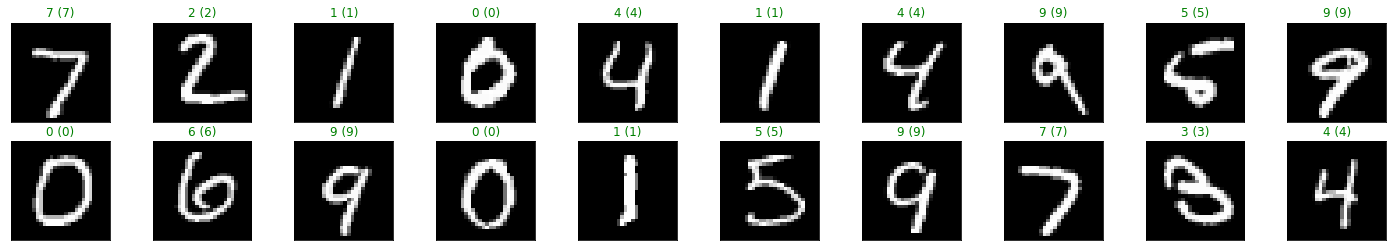

In [31]:
images, labels = iter(test_loader).next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy().squeeze()
labels = labels.numpy()
visualize_batch(images, labels, preds)